In [2]:
# load libraries
library(dplyr)
library("edgeR")
library(Matrix)
library(gplots)
library(RColorBrewer)
library(irlba) 
library(proxy)
library(png)
library(tidyverse)
library(ComplexHeatmap)
library(here)


working_dir <- "/scratch/jpm73279/comparative_single_cell/08.annotation_figures/panicum_millet"

# load arguments
#args <- commandArgs(T)
#if(length(args)!=5){stop("Rscript normGBA.R <gene.sparse> <meta> <Zea_mays.AGPv4.36.Allgene.nuclear.bed> <prefix> <F>")}
#input_data <- as.character(args[1])
#meta <- as.character(args[2])
#gene <- as.character(args[3])
#prefix <- as.character(args[4])



#gene_bodysorghum_bicolor_tis_leaf_nmf_step_2_knn_27.out.de_novo.rds
input <- here(working_dir,"panicum_millet.gene_body_acc_leaf.counts.txt")
#input_2 <- here("/home/jpm73279/r_script_dev/lw_plotting","zea_mays.normalized_gene_acc_scores.leaf_svd_knn_100_strict.GBaccessibility.sparse")
meta <- here("/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/pm_annot/Pm.leaf_annotation.V1.meta.txt")
gene <- here(working_dir,"Pm.final_all_markers.visualize.txt")
gene_DA <- here(working_dir,"Pmiliaceum.genes.bed")
#prefix <- "TEST_SORGHUM_TEST"

meta_data <- read.delim(meta)
gene_markers <- read.delim(gene)

multiple_gene_markers <- gene_markers %>% 
    group_by(name) %>% 
    summarise(counts = n()) %>% 
    dplyr::filter(counts > 1)

`%ni%` <- Negate(`%in%`)
gene_markers <- gene_markers  %>%
    arrange(type) %>% 
    select(chr, start, end, geneID, name) %>% 
    mutate(name) %>%  
    dplyr::filter(name %ni% multiple_gene_markers$name)

In [3]:
str(gene_markers)

'data.frame':	5055 obs. of  5 variables:
 $ chr   : chr  "CM009702.2" "CM009693.2" "CM009692.2" "CM009704.2" ...
 $ start : int  36232957 33644801 3227521 27374131 24128163 22877327 2780990 25024491 1297590 49161219 ...
 $ end   : int  36236810 33650122 3232897 27375037 24128876 22882572 2787560 25032099 1305071 49168186 ...
 $ geneID: chr  "RLN03609.1" "RLM87580.1" "RLN35181.1" "RLM73768.1" ...
 $ name  : chr  "ig1" "ocl3_ortho_count_1" "ocl3_ortho_count_2" "fcp1_ortho_count_1" ...


In [4]:
gene_markers %>% 
    group_by(name) %>% 
    summarise(counts = n()) %>% 
    dplyr::filter(counts > 1)

name,counts
<chr>,<int>


In [5]:
unique(meta_data$cell_type)
`%ni%` <- Negate(`%in%`)

meta_data  <- meta_data %>%
  mutate(final_annotation = reduce_resolution_annotation) %>% 
  mutate(cell_type = case_when(final_annotation == "phloem_sieve_elements" ~ "companion_cells/sieve_elements",
                               final_annotation == "companion_cells" ~ "companion_cells/sieve_elements",
                               final_annotation == "companion_cells_sieve_elements" ~ "companion_cells/sieve_elements",
                               final_annotation == "mesophyll;developing" ~ "mesophyll developing",
                               TRUE ~ final_annotation)) %>% 
  dplyr::filter(is.na(cell_type) != TRUE)  %>%  
  mutate(cell_type = str_replace_all(cell_type, "_", " "))  %>% 
  mutate_at(vars(cell_type), 
            list(factor)) %>% 
  dplyr::filter(cell_type != "unknown;1")

meta_data  %>% 
    group_by(cell_type)  %>% 
    summarise(counts = n())


NULL

cell_type,counts
<fct>,<int>
bundle sheath,963
companion cells/sieve elements,412
epidermis,919
mesophyll,2921
procambium,550
protoderm,1315


In [6]:
all_markers <- gene_markers$geneID

raw_cpm_counts_all_genes <- read_delim(input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)

colnames(meta_data)

merged_meta_cpm_information <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
    group_by(cell_type, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

### Alt CPM Calc
merged_meta_cpm_information_copied <- merged_meta_cpm_information
catch <- merged_meta_cpm_information_copied  %>%
    group_by(cell_type) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()



caught_values <- as_tibble(catch)
see <- ungroup(merged_meta_cpm_information_copied)
merged_meta_cpm_information_copied<- bind_cols(merged_meta_cpm_information_copied,caught_values)  %>% 
    rename(grouped_CPM = value)

head(merged_meta_cpm_information_copied)

head(merged_meta_cpm_information_copied)
altered_deseq2 <- merged_meta_cpm_information_copied %>% 
    dplyr::select(-counts) %>% 
    pivot_wider(names_from = geneID, values_from = grouped_CPM, values_fill = 0) %>% 
    pivot_longer(cols = -cell_type, names_to = "geneID", values_to = "grouped_CPM") %>% 
    group_by(geneID) %>% 
    mutate(Zscore = scale(grouped_CPM)) %>% 
    mutate(Zscore = as.numeric(Zscore))%>% 
    ungroup()  %>% 
    #mutate(relative_accessability = rescale(Zscore, to = c(0,1))) %>% 
    group_by(cell_type)  %>% 
    mutate(Zscore_group = scale(Zscore))

Rows: 54642541 Columns: 3
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "cellID"                       "total"                       
 [3] "tss"                          "acrs"                        
 [5] "ptmt"                         "nSites"                      
 [7] "log10nSites"                  "pTSS"                        
 [9] "FRiP"                         "pOrg"                        
[11] "tss_z"                        "acr_z"                       
[13] "sites_z"                      "qc_check"                    
[15] "background"                   "cellbulk"                    
[17] "is_cell"                      "sampleID"                    
[19] "umap1"                        "umap2"                       
[21] "doubletscore"                 "d.type"                      
[23] "LouvainClusters"              "Louvain_cluster_safe"        
[25] "cell_annotation_glmnet"       "cell_annotation_knn"         
[27] "cell_annotation_enrich"       "cell_annotation_smooth"      
[29] "cluster_annotation_glmnet"    "cluster_annotation_knn"      
[31] "cluster_annotation_smooth"    "cluster_annotation_enrich"   
[33] "annotation_v1"                "subcluster_lc_safe"          
[35] "umap1.subcluster"             "umap2.subcluster"            
[37] "annotation_v1_safe"           "counts"                      
[39] "annotation_v1_ncell"          "reduce_resolution_annotation"
[41] "final_annotation"             "cell_type"

`summarise()` has grouped output by 'cell_type'. You can override using the
`.groups` argument.


cell_type,geneID,counts,grouped_CPM
<fct>,<chr>,<dbl>,<dbl>
bundle sheath,C2845_PMCG10002,2296,380.855192
bundle sheath,C2845_PMCG10004,151,25.047532
bundle sheath,C2845_PMCG10007,25,4.146942
bundle sheath,C2845_PMCG10009,82,13.601971
bundle sheath,C2845_PMCG10011,221,36.658971
bundle sheath,C2845_PMCG10012,221,36.658971


cell_type,geneID,counts,grouped_CPM
<fct>,<chr>,<dbl>,<dbl>
bundle sheath,C2845_PMCG10002,2296,380.855192
bundle sheath,C2845_PMCG10004,151,25.047532
bundle sheath,C2845_PMCG10007,25,4.146942
bundle sheath,C2845_PMCG10009,82,13.601971
bundle sheath,C2845_PMCG10011,221,36.658971
bundle sheath,C2845_PMCG10012,221,36.658971


In [7]:
# Create Proportion Cells Accessible Metrics ------------------------------
merged_meta_cellID_values <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))
take_unq_genes <- unique(merged_meta_cellID_values$geneID)


merged_meta_cellID_values_all_genes <- merged_meta_cellID_values %>% 
    select(cellID, cell_type, accessability, geneID) 

dim(merged_meta_cellID_values_all_genes)

dim(unique(merged_meta_cellID_values_all_genes))

merged_meta_cellID_values_all_genes  %>% 
    group_by(cellID, cell_type, accessability, geneID)  %>% 
    summarise(counts=n())  %>% 
    dplyr::filter(counts > 1)

colnames(merged_meta_cellID_values_all_genes)
colnames(merged_meta_cellID_values_all_genes)

wider_all_genes_altered <- merged_meta_cellID_values_all_genes %>% 
                    distinct()  %>% 
                    pivot_wider(names_from = geneID, 
                                values_from = accessability,  
                                values_fill = 0) %>% 
                    pivot_longer(cols = c(-cell_type, -cellID), 
                                 names_to = "geneID", 
                                 values_to = "accessability") %>% 
                    mutate(expression_bool = case_when(accessability < 1 ~ 0,
                                                       accessability >= 1 ~ 1)) %>% 
                    group_by(cell_type, geneID) %>% 
                    summarise(total_cells = n(), 
                              proportion_expressing = (sum(expression_bool)/total_cells * 100))

[1] 16685086        4

[1] 16685086        4

`summarise()` has grouped output by 'cellID', 'cell_type', 'accessability'. You
can override using the `.groups` argument.


cellID,cell_type,accessability,geneID,counts
<chr>,<fct>,<dbl>,<chr>,<int>


[1] "cellID"        "cell_type"     "accessability" "geneID"

[1] "cellID"        "cell_type"     "accessability" "geneID"

`summarise()` has grouped output by 'cell_type'. You can override using the
`.groups` argument.


In [8]:
### 7/23/2022 List of maarkers
good_marker_list <- c("sweet13a_ortho_count_1__sweet13b_ortho_count_1__sweet13c_ortho_count_1", "sweet13a_ortho_count_2__sweet13b_ortho_count_2__sweet13c_ortho_count_2",                                                                                                                                             "sweet13a_ortho_count_3__sweet13b_ortho_count_3__sweet13c_ortho_count_3", "ba2_ortho_count_1",                                                          "ba2_ortho_count_2", "acl1_ortho_count_1",                                                                                                              "acl1_ortho_count_2", "bhlh43_ortho_count_1",                                                                                                           "bhlh43_ortho_count_2", "bhlh43_ortho_count_3",                                                                                                         "ssu2_ortho_count_1__ssu1_ortho_count_1", "ssu2_ortho_count_2__ssu1_ortho_count_2",                                                                     "ssu2_ortho_count_3__ssu1_ortho_count_3", "ssu2_ortho_count_4__ssu1_ortho_count_4",                                                                     "ssu2_ortho_count_5__ssu1_ortho_count_5", "ssu2_ortho_count_6__ssu1_ortho_count_6",                                                                     "ssu2_ortho_count_7__ssu1_ortho_count_7", "sut1_ortho_count_1__sut7_ortho_count_1",                                                                     "sut1_ortho_count_2__sut7_ortho_count_2", "KCS1",                                                                                                       "gpat11_ortho_count_1__gpat12_ortho_count_1", "gpat11_ortho_count_2__gpat12_ortho_count_2",                                                             "scr1h_ortho_count_1__scr1_ortho_count_1", "scr1h_ortho_count_2__scr1_ortho_count_2",                                                                   "scr1h_ortho_count_3__scr1_ortho_count_3", "mute_ortho_count_1",
"mute_ortho_count_2", "fcp1_ortho_count_1",
"fcp1_ortho_count_2", "ids1_ortho_count_1",
"ids1_ortho_count_2", "ids1_ortho_count_3",
"zyb14", "ZmSWEET11_ortho_count_1",
"ZmSWEET11_ortho_count_2", "ZmSWEET11_ortho_count_3",
"cvp2_ortho_count_1", "cvp2_ortho_count_2",
"agp2", "ZmLAX2_ortho_count_1",
"ZmLAX2_ortho_count_2", "pdf2_ortho_count_1",
"pdf2_ortho_count_2", "pdf1",
"ad1_ortho_count_1", "ad1_ortho_count_2",
"ocl5_ortho_count_1", "ocl5_ortho_count_2",
"ocl4_ortho_count_1", "ocl4_ortho_count_2",
"ZmAPL", "ZmLRD3_ortho_count_1",
"ZmLRD3_ortho_count_2", "ZmSMXL5_ortho_count_1",
"ZmSMXL5_ortho_count_2", "sweet1b_ortho_count_1",
"sweet1b_ortho_count_2", "ccr1_ortho_count_1",
"ccr1_ortho_count_2", "bm5_ortho_count_1",
"bm5_ortho_count_2", "vt2_ortho_count_1",
"vt2_ortho_count_2",
                     "AspAT_1",
"AspAT_2",
"AspAT_3",
"AspAT_4",
"CA_1",
"CA_2",
"DIC1_",
"Dit_1",
"Dit_2",
"Dit_3",
"NAD-ME_1",
"NAD-ME_2",
"NADP-MDH_1",
"NADP-MDH_2",
"NADP-MDH_3",
"NADP-ME_1",
"NADP-ME_2",
"PEP-CK_1",
"PEP-CK_2",
"PEP-CK_3",
"PEPC_1",
"PEPC_2",
"PPA1",
"PPA2_1",
"PPA2_2",
"PPA3_1",
"PPA3_2",
"PPDK_1",
"PPDK_2",
"PPDK-RP",
"PPT_1",
"PPT_2",
"PPT_3",
"PPT_4",
"rca1_ortho_count_1",
"rca1_ortho_count_2",
"rca3_ortho_count_1",
"rca3_ortho_count_2",
"rca4_ortho_count_1",
"rca4_ortho_count_2",
"cah6_ortho_count_1",
"cah6_ortho_count_2",
"cah6_ortho_count_3",
"cah6_ortho_count_4",
"cah5_ortho_count_1__cah4_ortho_count_1",
"cah5_ortho_count_2__cah4_ortho_count_2",
"bass1_ortho_count_1",
"bass1_ortho_count_2")

good_gene_markers <- gene_markers  %>% 
    filter(name %in% good_marker_list)
head(good_gene_markers)

marker_final_plotting <- left_join(altered_deseq2, wider_all_genes_altered, by = c("cell_type", "geneID")) %>% 
        left_join(., gene_markers, by = c("geneID"))

,chr,start,end,geneID,name
,<chr>,<int>,<int>,<chr>,<chr>
1,CM009704.2,27374131,27375037,RLM73768.1,fcp1_ortho_count_1
2,CM009705.2,24128163,24128876,RLM66178.1,fcp1_ortho_count_2
3,CM009694.2,19782899,19785001,RLN28288.1,sweet13a_ortho_count_1__sweet13b_ortho_count_1__sweet13c_ortho_count_1
4,CM009695.2,36539236,36541084,RLN01113.1,sweet13a_ortho_count_2__sweet13b_ortho_count_2__sweet13c_ortho_count_2
5,CM009695.2,36526523,36528785,RLM98289.1,sweet13a_ortho_count_3__sweet13b_ortho_count_3__sweet13c_ortho_count_3
6,CM009704.2,22710647,22722763,RLM73190.1,ba2_ortho_count_1


Warning message in left_join(., gene_markers, by = c("geneID")):
"Detected an unexpected many-to-many relationship between `x` and `y`.
i Row 2980 of `x` matches multiple rows in `y`.
i Row 153 of `y` matches multiple rows in `x`.
i If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning."


In [9]:
test_marker_clust <- marker_final_plotting  %>% 
    filter(geneID %in% good_gene_markers$geneID)  %>% 
    ungroup() %>% 
    dplyr::select(cell_type, Zscore, name)  %>% 
    pivot_wider(names_from = cell_type, values_from = Zscore) %>% 
      data.frame() # make df as tibbles -> matrix annoying

row.names(test_marker_clust) <- test_marker_clust$name  # put gene in `row`
test_marker_clust <- test_marker_clust[,-1] #drop gene column as now in rows
clust <- hclust(dist(test_marker_clust %>% as.matrix())) # hclust with distance matrix

In [10]:
mat <- marker_final_plotting %>% 
    filter(geneID %in% good_gene_markers$geneID)  %>% 
    ungroup() %>% 
    dplyr::select(cell_type, Zscore, name)  %>% 
    pivot_wider(names_from = cell_type, values_from = Zscore) %>% 
      data.frame() # make df as tibbles -> matrix annoying
row.names(mat) <- mat$name  # put gene in `row`
mat <- mat[,-1] #drop gene column as now in rows
v_clust <- hclust(dist(mat %>% as.matrix() %>% t())) # hclust with distance matrix

fixed_order_strings <- v_clust$labels[v_clust$order]
fixed_order_strings <- gsub("companion.cells.sieve.elements", "companion cells/sieve elements", fixed_order_strings)
fixed_order_strings <- gsub("\\.", " ", fixed_order_strings)


In [11]:
options(repr.plot.width=10, repr.plot.height=17)


pm.dotplot_catch <- marker_final_plotting  %>% 
    mutate(Gene_name = factor(name, clust$labels[clust$order]),
          Cluster_name = factor(cell_type, levels = fixed_order_strings)) %>% 
    filter(is.na(Gene_name) != TRUE) %>% 
    ggplot(., aes(x=Cluster_name, y = Gene_name, 
                               color = Zscore, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90)) + scale_colour_gradient2() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.line.x = element_line(color="black", size = 1), axis.line.y = element_line(color="black", size = 1)) +
    ggtitle("Pm Z Score of Markers - Across Annotations")





Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


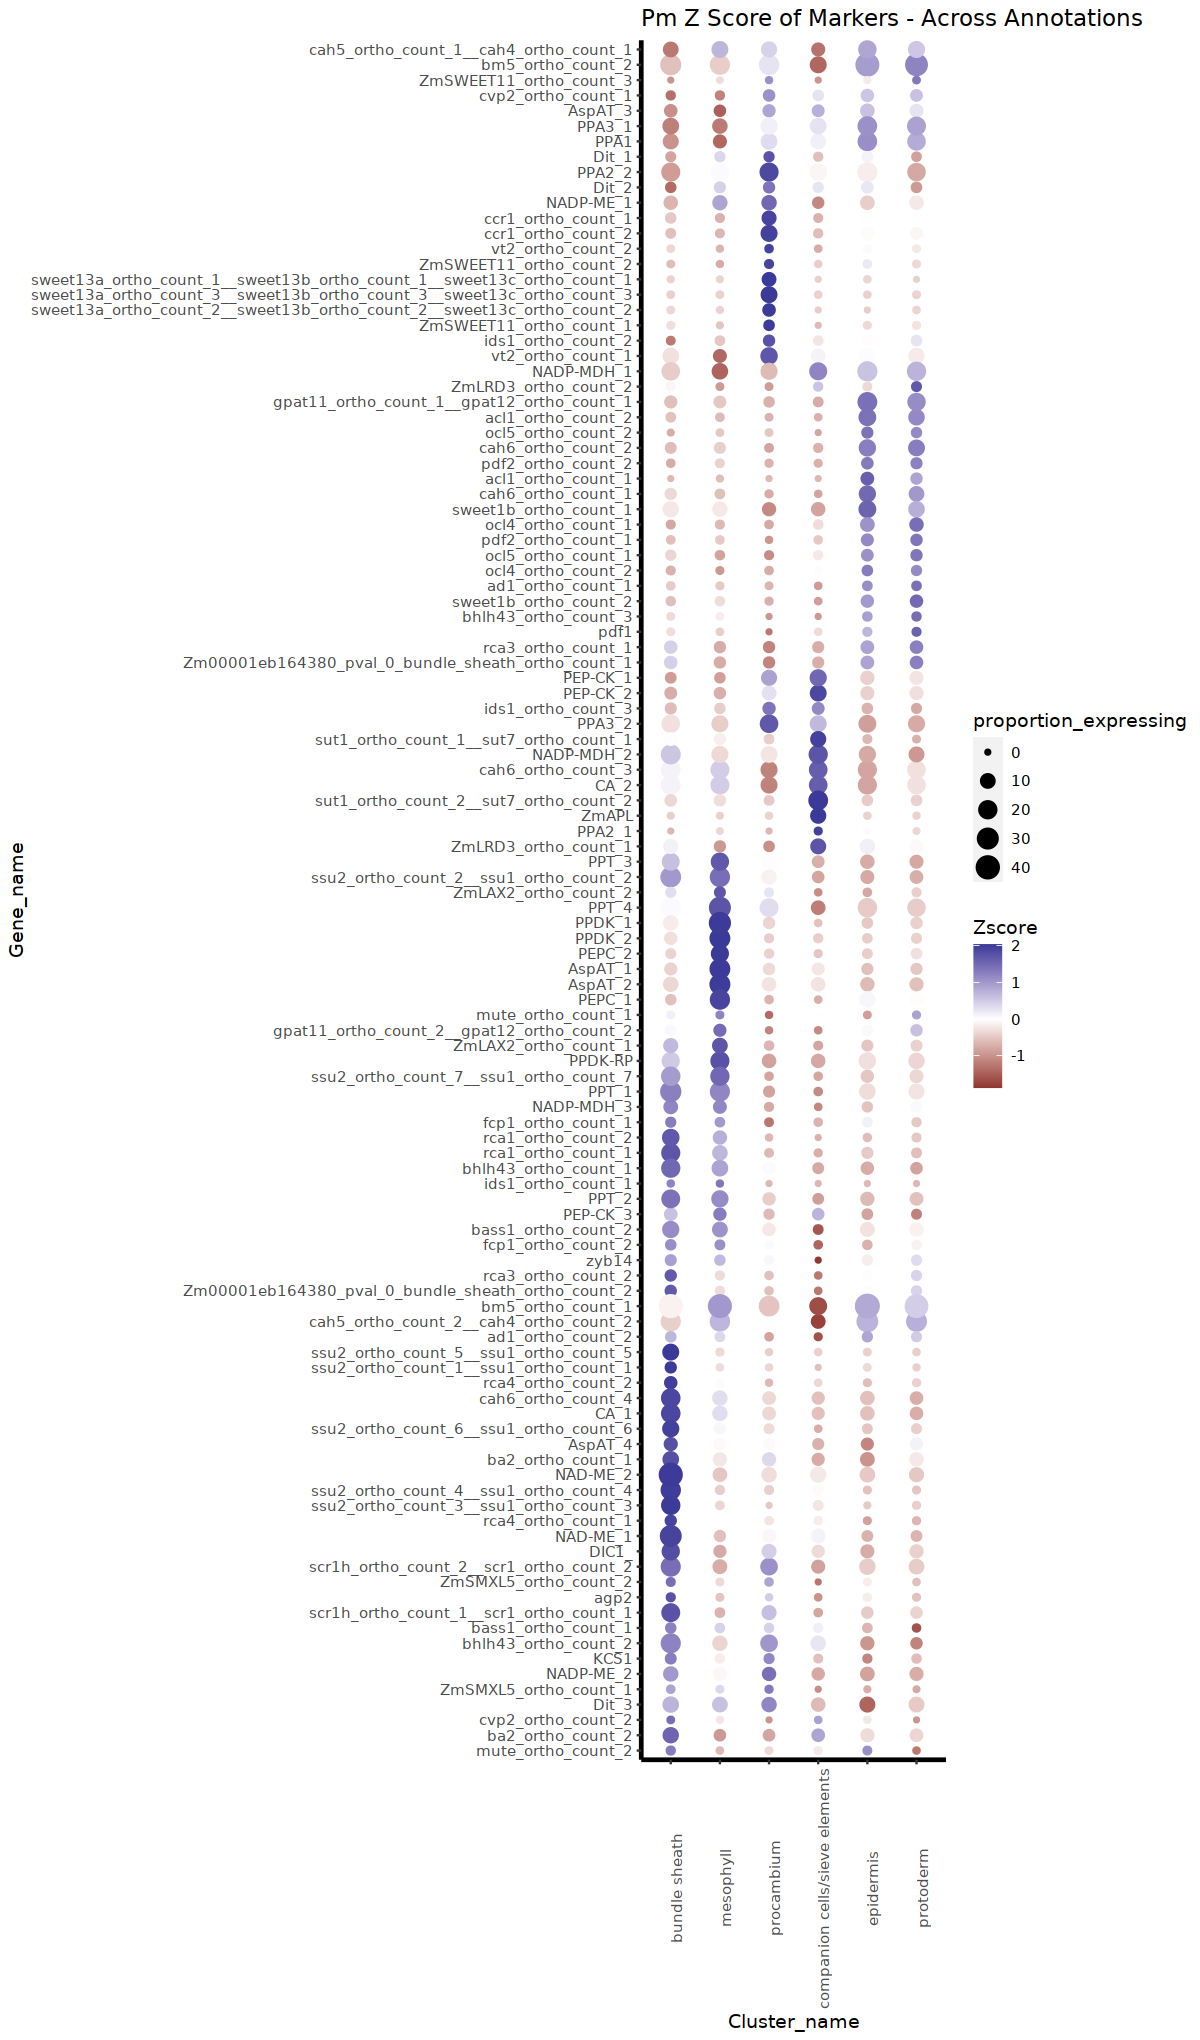

In [12]:
pm.dotplot_catch

In [13]:
ggsave("Pm_all_markers_dotplot.supplament.pdf", plot = pm.dotplot_catch,
    path = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_1/dotplots",
    width = 10, height = 17,
    units = c('in'), limitsize = FALSE, dpi = 300)

In [14]:
### 5/19/2023 Markers selected for Figure 1

figure_marker_list <- c("ZmAPL", "sut1_ortho_count_2__sut7_ortho_count_2", "ZmLRD3_ortho_count_1", ##companion Cells
"ssu2_ortho_count_4__ssu1_ortho_count_4", "NAD-ME_2", "Dit_3",# Bundle sheath
"PPDK_2", "cah6_ortho_count_3", "PEPC1", #mesophyll/developing mesophyll
"gpat11_ortho_count_1__gpat12_ortho_count_1", "gl1_ortho_count_2",  #Epidermis 
"ocl4_ortho_count_2", "pdf1", "pdf2",#protoderm
"scr1h_ortho_count_1__scr1_ortho_count_1", "vt2_ortho_count_2","ZmOPS_ortho_count_2", "shr1_ortho_count_1", "cvp2_ortho_count_2"  # Procambial merisemt
)
                       




In [15]:
good_gene_markers <- gene_markers  %>% 
    filter(name %in% figure_marker_list)


marker_final_plotting <- left_join(altered_deseq2, wider_all_genes_altered, by = c("cell_type", "geneID")) %>% 
        left_join(., gene_markers, by = c("geneID"))

#test_marker_clust <- marker_final_plotting  %>% 
#    filter(geneID %in% good_gene_markers$geneID)  %>% 
#    ungroup() %>% 
##    dplyr::select(cell_type, Zscore, name)  %>% 
 #   pivot_wider(names_from = cell_type, values_from = Zscore) %>% 
#      data.frame() # make df as tibbles -> matrix annoying

#row.names(test_marker_clust) <- test_marker_clust$name  # put gene in `row`
#test_marker_clust <- test_marker_clust[,-1] #drop gene column as now in rows
#clust <- hclust(dist(test_marker_clust %>% as.matrix())) # hclust with distance matrix

#mat <- marker_final_plotting %>% 
#    filter(geneID %in% good_gene_markers$geneID)  %>% 
#    ungroup() %>% 
#    dplyr::select(cell_type, Zscore, name)  %>% 
#    pivot_wider(names_from = cell_type, values_from = Zscore) %>% 
#      data.frame() # make df as tibbles -> matrix annoying
#row.names(mat) <- mat$name  # put gene in `row`
#mat <- mat[,-1] #drop gene column as now in rows
#v_clust <- hclust(dist(mat %>% as.matrix() %>% t())) # hclust with distance matrix

Warning message in left_join(., gene_markers, by = c("geneID")):
"Detected an unexpected many-to-many relationship between `x` and `y`.
i Row 2980 of `x` matches multiple rows in `y`.
i Row 153 of `y` matches multiple rows in `x`.
i If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning."


In [16]:
figure_marker_list <- c("ZmAPL", "sut1_ortho_count_2__sut7_ortho_count_2", "ZmLRD3_ortho_count_1", ##companion Cells
"ssu2_ortho_count_4__ssu1_ortho_count_4", "ssu2_ortho_count_3__ssu1_ortho_count_3", "NAD-ME_2", "Dit_3",# Bundle sheath
"PPDK_2", "cah6_ortho_count_3", "PEPC_1", #mesophyll/developing mesophyll
"gpat11_ortho_count_1__gpat12_ortho_count_1", "gl1_ortho_count_2",  #Epidermis 
"ocl4_ortho_count_2", "ocl1_ortho_count_2", "pdf1", "pdf2",#protoderm
"vt2_ortho_count_2","ZmOPS_ortho_count_2", "cvp2_ortho_count_1", "shr2h_ortho_count_2__shr2_ortho_count_2" # Procambial merisemt
)
                       
good_gene_markers <- gene_markers  %>% 
    filter(name %in% figure_marker_list)

marker_final_plotting <- left_join(altered_deseq2, wider_all_genes_altered, by = c("cell_type", "geneID")) %>% 
        left_join(., gene_markers, by = c("geneID"))

Warning message in left_join(., gene_markers, by = c("geneID")):
"Detected an unexpected many-to-many relationship between `x` and `y`.
i Row 2980 of `x` matches multiple rows in `y`.
i Row 153 of `y` matches multiple rows in `x`.
i If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning."


Warning message:
"package 'scales' was built under R version 4.2.1"

Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor




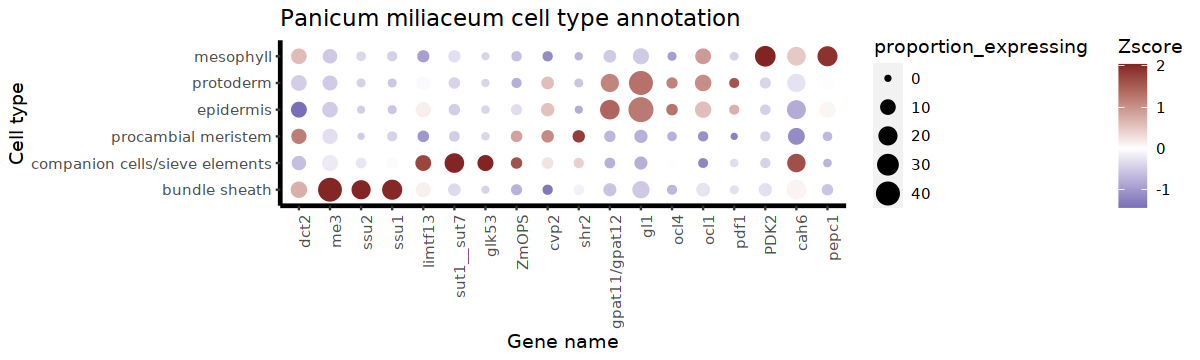

In [17]:

library(scales) # for muted

gene_order <- c('dct2', 'me3', 'ssu2', "ssu1",'limtf13', 'sut1__sut7', 'glk53', 
                'ZmOPS', 'cvp2', 'shr2', 
                'gpat11/gpat12', 'gl1',
                'ocl4', 'ocl1', 'pdf2', 'pdf1',
                'PDK2', 'cah6', 'cah1', 'pepc1')


cell_type_order <- c('bundle sheath', 'companion cells/sieve elements', 'procambial meristem', 
                'epidermis', 'protoderm', 'mesophyll', 'mesophyll developing')


options(repr.plot.width=10, repr.plot.height=3)
pm_figure_marker_dotplot <- marker_final_plotting  %>% 
    dplyr::mutate(cell_type = case_when(cell_type == "procambium" ~  "procambial meristem",
                            TRUE ~ cell_type) ) %>% 
    dplyr::filter(name %in% figure_marker_list) %>% 
   dplyr::mutate(name = case_when(name == "PEPC_1" ~ "pepc1", 
                                  name == "sut1_ortho_count_2__sut7_ortho_count_2" ~ "sut1__sut7", 
                                  name == "ssu2_ortho_count_4__ssu1_ortho_count_4" ~ "ssu1", 
                                  name == "ssu2_ortho_count_3__ssu1_ortho_count_3" ~ "ssu2", 
                                   name == "PPDK_2" ~ "PDK2",
                                   name == "gpat11_ortho_count_1__gpat12_ortho_count_1" ~ "gpat11/gpat12",
                                   name == "cah6_ortho_count_3" ~ "cah6", 
                                   name == "Dit_3" ~ "dct2",
                                   name == "ZmAPL" ~ "glk53",
                                   name == "ZmLRD3_ortho_count_1" ~ "limtf13",
                                   name == "NAD-ME_2" ~ "me3",
                                   name == "shr1_v4v5count_1" ~ "gras58",
                                   name == "gl1_ortho_count_2" ~ "gl1",
                                   name == "cvp2_ortho_count_1" ~ "cvp2",
                                  name == "shr2h_ortho_count_2__shr2_ortho_count_2" ~ "shr2",
                                  name =="ocl4_ortho_count_2" ~ "ocl4",
                                  name =="ocl1_ortho_count_2" ~ "ocl1",
                                  name == "pdf2_ortho_count_1" ~ "pdf2",
                                  name == "vt2_ortho_count_2" ~ "vt2",
                                  name == "ZmOPS_ortho_count_2" ~ "ZmOPS",
                                   TRUE ~ name
                                  )) %>%  
    mutate(Gene_name = factor(name, levels = gene_order),
           Cluster_name = factor(cell_type, levels = cell_type_order)) %>% 
    filter(is.na(Gene_name) != TRUE) %>% 
    ggplot(., aes(y=Cluster_name, x = Gene_name, 
                  color = Zscore, size = proportion_expressing)) + 
    geom_point() + theme(axis.text.x = element_text(angle = 90, hjust = 1)) +     
    scale_colour_gradient2(low= muted("blue"), high=muted("red")) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
          panel.background = element_blank(), axis.line.x = element_line(color="black", size = 1), 
          axis.line.y = element_line(color="black", size = 1),
                   legend.box = "horizontal") + # align the legends horizontally) +
    ggtitle("Panicum miliaceum cell type annotation") +
    labs(x = "Gene name", y = "Cell type")  # This line was added

pm_figure_marker_dotplot

In [19]:
ggsave("Pm_selected_marker_dotplot.main_figure.pdf", plot = pm_figure_marker_dotplot,
    path = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_1/dotplots",
    width = 10, height = 3,
    units = c('in'), limitsize = FALSE, dpi = 300)